# Strain mapping with all calibrations
___

## 4A: Measure lattice strain - Initial lattice vector guess

Get a rough guess at the lattice vectors.  Here the approach is to take a Radon transform of the Bragg vector map in order to find high symmetry orientations.  You can also manually select an initial guess - see, e.g., py4DSTEM/notebooks/module_demos/lattice_vectors/intialguess_manualselection.ipynb.
___

- Inputs:
  - Bragg peaks, corrected, for the experimental sample
- Outputs:
  - lattice vectors, initial guess

### Import packages, load data

In [22]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import radon

from py4DSTEM.file.datastructure import PointList
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import get_radon_scores, get_lattice_directions_from_scores, get_lattice_vector_lengths

In [23]:
# Examine contents of processing_sampledata.h5

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp_processing)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_calibrationdata_shiftcorrectedDiffractionSlice    
   1    braggvectormap_corrected_calibrationdataDiffractionSlice    
   2    braggvectormap_corrected_experiment DiffractionSlice    
   3    braggvectormap_experiment_shiftcorrectedDiffractionSlice    
   4    braggvectormap_uncorrected_calibrationdataDiffractionSlice    
   5    braggvectormap_uncorrected_experimentDiffractionSlice    
   6    probe                               DiffractionSlice    
   7    diffractionshifts_calibrationdata   RealSlice           
   8    diffractionshifts_experiment        RealSlice           
   9    virtual_image                       RealSlice           
   10   Qpixel_calibration                  PointList           
   11   RQ_rotational_offset_degrees        PointList           
   12   elliptical_distortion               PointList           
   13   lattice_vectors                     PointList           
 

In [24]:
# Load data

braggpeaks = browser.get_dataobject('braggpeaks_corrected_experiment')
braggvectormap = browser.get_dataobject('braggvectormap_corrected_experiment').data
browser.close()

Q_Nx,Q_Ny = braggvectormap.shape

### Take radon transform of Bragg vector map

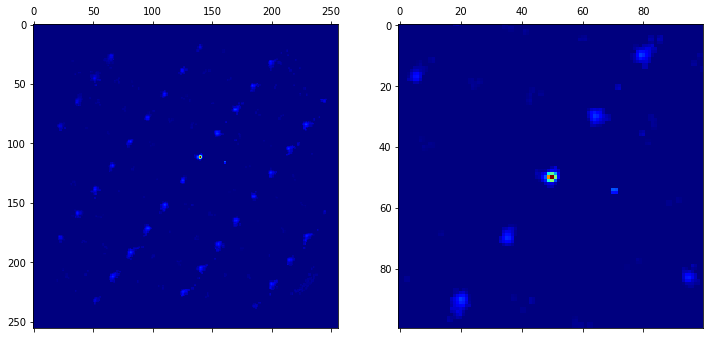

In [25]:
# Show Bragg vector map

power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,sigma=2)),(Q_Nx,Q_Ny))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(braggvectormap**power,cmap='jet')
ax2.matshow(braggvectormap[x0-50:x0+50,y0-50:y0+50]**power,cmap='jet')
plt.show()

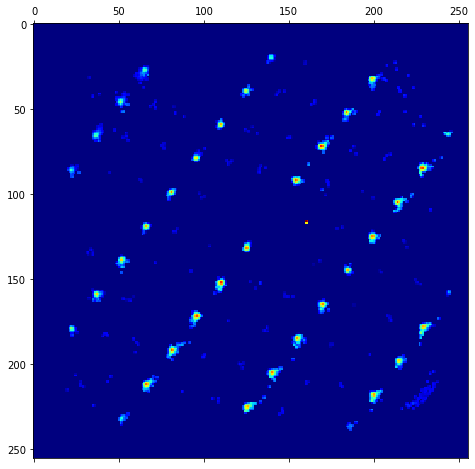

In [26]:
# Get mask for unscattered beam

maskrad = 10
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,sigma=2)),(Q_Nx,Q_Ny))
ry,rx = np.meshgrid(np.arange(Q_Ny),np.arange(Q_Nx))
mask = ((rx-x0)**2+(ry-y0)**2) > maskrad**2

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((braggvectormap*mask)**power,cmap='jet')
plt.show()

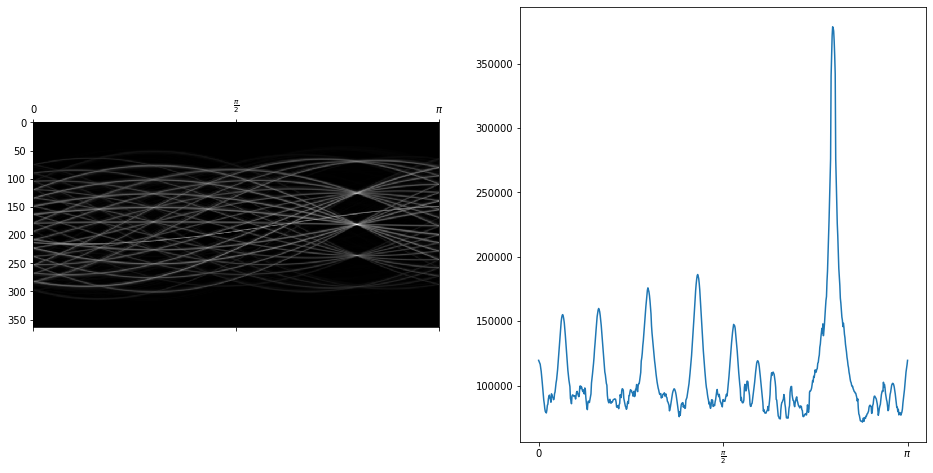

In [27]:
# Get scores

N_angles = 720
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05

power = 0.5

scores, thetas, sinogram = get_radon_scores(braggvectormap, mask, N_angles, sigma, minSpacing, minRelativeIntensity)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

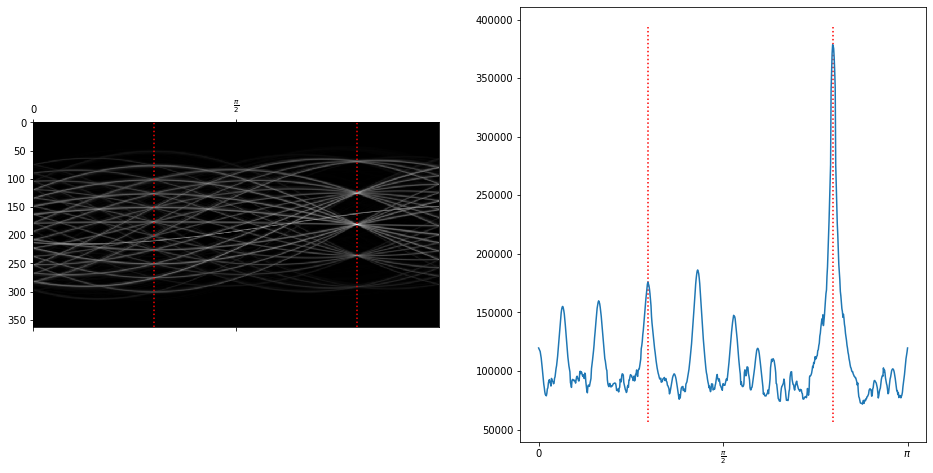

Initial guess at u and v angles is 143.7 and 53.32, respectively.


In [28]:
# Get lattice directions

sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05
index1 = 0
index2 = 1

power = 0.5

u_theta, v_theta = get_lattice_directions_from_scores(thetas, scores, sigma, minSpacing, minRelativeIntensity,
                                                                                         index1, index2)

u_theta_ind = np.argmin(np.abs(thetas-u_theta))
v_theta_ind = np.argmin(np.abs(thetas-v_theta))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.vlines((u_theta_ind,v_theta_ind),ax1.get_ylim()[0],ax1.get_ylim()[1],linestyle=":",color='r')
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.vlines((u_theta,v_theta),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyle=":",color='r')
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

print("Initial guess at u and v angles is {:.4} and {:.4}, respectively.".format(np.degrees(u_theta),np.degrees(v_theta)))

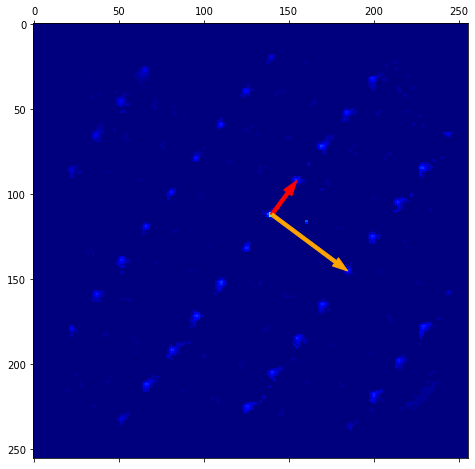

In [30]:
# Get lattice vector lengths

spacing_thresh = 1.5
sigma = 2
minSpacing = 2
minRelativeIntensity = 0.2

power = 0.25

u_length, v_length = get_lattice_vector_lengths(u_theta, v_theta, thetas, sinogram,
                                                spacing_thresh, sigma, minSpacing, minRelativeIntensity)

# Show
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,sigma=2)),(Q_Nx,Q_Ny))
u_dx = np.cos(u_theta)*u_length
u_dy = np.sin(u_theta)*u_length
v_dx = np.cos(v_theta)*v_length
v_dy = np.sin(v_theta)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power,cmap='jet')
ax.arrow(y0,x0,u_dy,u_dx, color='red',width=2,length_includes_head=True)
ax.arrow(y0,x0,v_dy,v_dx, color='orange',width=2,length_includes_head=True)
plt.show()

### Save lattice vectors

In [39]:
# Make pointlist

coordinates = [('qx',float),('qy',float)]
lattice_vectors = PointList(coordinates, name='lattice_vectors')
lattice_vectors.add_point((u_dx,u_dy))
lattice_vectors.add_point((v_dx,v_dy))

In [40]:
# Append to processing file

append(lattice_vectors, fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/processing_sampledata.h5...
Done.
